In [1]:
# Import libraries
import boto3
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib
from io import BytesIO, StringIO
from datetime import datetime, timezone, date
import geopandas as gpd
import contextily as cx

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/victoriaford/anaconda3/envs/histobs/lib/python3.11/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.9.1dev-CAPI-1.14.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [5]:
vars_to_plot = ['tas', 'tdps', 'hurs', 'sfcwind', 'sfcwind_dir', 'rsds']
# version where all ps and pr vars are included
# version where all ps vars and all pr vars are grouped into "ps" and "pr"

In [ ]:
## Current counts of # of stations with observations per variable
# tas: 13,891
# tdps: 1,040
# tdps_derived: 10,670
# ps: 1,087
# psl: 738
# ps_altimeter: 8,712
# pr: 9,171
# pr_5min: 555
# pr_1h: 1,913
# pr_24h: 6,808
# pr_localmid: 5,433
# hurs: 10,797
# sfcwind: 11,780
# sfcwind_dir: 11,720
# rsds: 6,344

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


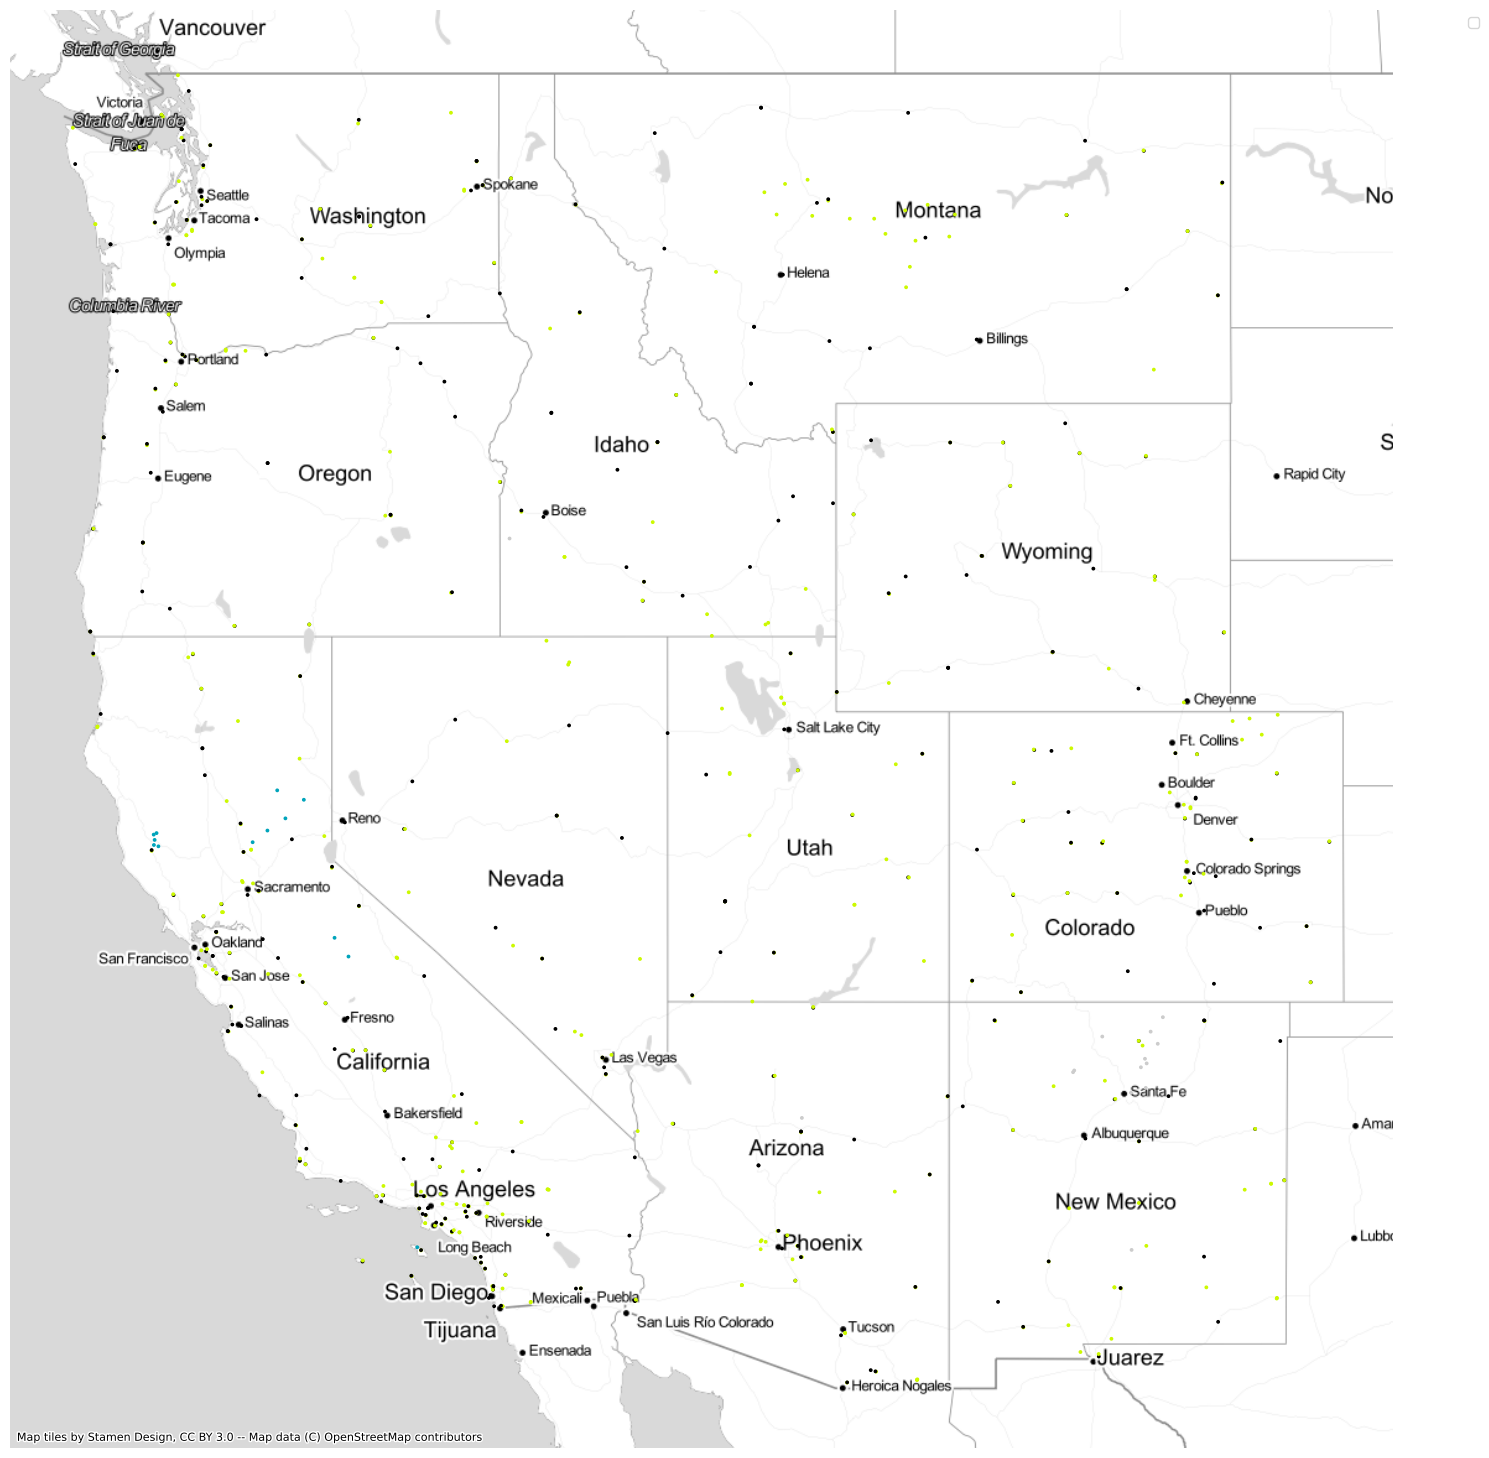

In [41]:
# Run function - generate station map
def single_var_map(df, var, shapepath):
    
    # Read in all stations
    s3 = boto3.resource("s3") 
    s3_cl = boto3.client('s3')
    
    bucket_name = "wecc-historical-wx"
    
    obj = s3_cl.get_object(Bucket = bucket_name, Key = "2_clean_wx/temp_clean_all_station_list.csv")
    body = obj['Body'].read()
    df_all = pd.read_csv(BytesIO(body), encoding='utf8')
    
    # Subset for variable of choice
    sub_df = df_all.loc[df_all[str(var)+"_nobs"] > 0]
    
    # ------------------------------------------------------------------------------------------------------------
    # Make a geodataframe
    gdf = gpd.GeoDataFrame(sub_df, geometry=gpd.points_from_xy(sub_df.longitude, sub_df.latitude))
    gdf.set_crs(epsg=4326, inplace=True) # Set CRS
    
    # Project data to match base tiles.
    gdf_wm = gdf.to_crs(epsg=3857) # Web mercator

    # Read in geometry of continental US.
    us = gpd.read_file(shapepath)

    # Remove territories, AK, HI
    rem_list = ["HI", "AK", "MP", "GU", "AS", "PR", "VI"]
    us = us.loc[us.STUSPS.isin(rem_list) == False]
    
    # Use to clip stations
    us = us.to_crs(epsg = 3857)
    gdf_us = gdf_wm.clip(us)

    # ------------------------------------------------------------------------------------------------------------
    # Version 1 - full map
    
    ax = gdf_us.plot("network", figsize=(15, 15), alpha=1, markersize = 3, legend = True, cmap = 'nipy_spectral')
    cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite)
    ax.set_axis_off()
    ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    
    # Title - make readable
    if var == "tas":
        var_title = "Air temperature ({})".format(var)
    elif var == "hurs":
        var_title = "Relative humidity ({})".format(var)
    elif var == "rsds":
        var_title = "Radiation ({})".format(var)
    elif var == "sfcwind":
        var_title = "Surface wind speed ({})".format(var)
    elif var == "sfcwind_dir":
        var_title = "Surface wind direction ({})".format(var)
    elif "pr" in var:
        var_title = "Precipitation ({})".format(var)
    elif "ps" in var and "td" not in var:
        var_title = "Air pressure ({})".format(var)

#     ax.set_title(var_title, loc='center', fontweight='bold', fontsize=18, pad=10)
    
    # Save to AWS
    img_data = BytesIO()
    plt.savefig(img_data, format='png')
    img_data.seek(0)

    bucket = s3.Bucket(bucket_name)
#     bucket.put_object(Body=img_data, ContentType='image/png', Key="2_clean_wx/clean_station_{}.png".format(var))
    
        
shapepath = "s3://wecc-historical-wx/0_maps/tl_2021_us_state.shp"
single_var_map(df, var = 'psl', shapepath = shapepath)

In [51]:
def gdf_setup(df, var):
    s3 = boto3.resource("s3") 
    s3_cl = boto3.client('s3')
    
    obj = s3_cl.get_object(Bucket = bucket_name, Key = "2_clean_wx/temp_clean_all_station_list.csv")
    body = obj['Body'].read()
    df_all = pd.read_csv(BytesIO(body), encoding='utf8')
    
    # Subset for variable of choice
    sub_df = df_all.loc[df_all[str(var)+"_nobs"] > 0]
    
    # ------------------------------------------------------------------------------------------------------------
    # Make a geodataframe
    gdf = gpd.GeoDataFrame(sub_df, geometry=gpd.points_from_xy(sub_df.longitude, sub_df.latitude))
    gdf.set_crs(epsg=4326, inplace=True) # Set CRS
    
    # Project data to match base tiles.
    gdf_wm = gdf.to_crs(epsg=3857) # Web mercator

    # Read in geometry of continental US.
    us = gpd.read_file(shapepath)

    # Remove territories, AK, HI
    rem_list = ["HI", "AK", "MP", "GU", "AS", "PR", "VI"]
    us = us.loc[us.STUSPS.isin(rem_list) == False]
    
    # Use to clip stations
    us = us.to_crs(epsg = 3857)
    gdf_us = gdf_wm.clip(us)
    
    return gdf_us

In [71]:
def var_fullname(var):
    """Returns the full name of variable for title purposes"""
    if var == "tas":
        var_title = "Air temperature ({})".format(var)
    if "tdps" in var:
        var_title = "Dewpoint temperature ({})".format(var)
    elif var == "hurs":
        var_title = "Relative humidity ({})".format(var)
    elif var == "rsds":
        var_title = "Radiation ({})".format(var)
    elif var == "sfcwind":
        var_title = "Surface wind speed ({})".format(var)
    elif var == "sfcwind_dir":
        var_title = "Surface wind direction ({})".format(var)
    elif "pr" in var:
        var_title = "Precipitation ({})".format(var)
    elif "ps" in var and "td" not in var:
        var_title = "Air pressure ({})".format(var)
    
    return var_title

In [122]:
def combo_var_map(df, multi_var, shapepath):
    
    ## figure global settings
    a=1 # alpha
    ms=2 # markersize
    l=True # legend
    cmap='nipy_spectral'
    fs=(16,12) # figure size
    
    # set up    
    bucket_name = "wecc-historical-wx"
    
    # set up - determine how many vars are passed
    if len(multi_var) == 1:
        single_var_map(df, multi_var[0], shapepath)
        
        
    elif len(multi_var) == 2: # one row
        fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,20))
        
        # subplot 1
        ax1 = gdf_setup(df, multi_var[0]).plot("network", figsize=fs, 
                                               ax=ax1, alpha=a, markersize=ms, legend=l, cmap=cmap)
        cx.add_basemap(ax1, source=cx.providers.Stamen.TonerLite)
        ax1.set_axis_off()
        vartitle = var_fullname(multi_var[0])
        ax1.set_title(vartitle, fontsize=16)
        
        # subplot 2
        ax2 = gdf_setup(df, multi_var[1]).plot("network", 
                                               ax=ax2, figsize=fs, alpha=a, markersize=ms, legend=l, cmap=cmap)
        cx.add_basemap(ax2, source=cx.providers.Stamen.TonerLite)
        ax2.set_axis_off()
        vartitle = var_fullname(multi_var[1])
        ax2.set_title(vartitle, fontsize=16)
        
        
        
    elif len(multi_var) > 3:
        for n, single_var in enumerate(multi_var):
            # add new subplot iteratively
            ax = plt.subplot(4, 3, n+1)
            print(n)
            
            
            ax = gdf_setup(df, multi_var[n].plot("network", ax=ax, figsize=fs, 
                                                alpha=a, markersize=ms, legend=l, cmap=cmap))
            cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite)
            ax.set_axis_off()
            vartitle = var_fullname(multi_var[n])
            ax.set_title(vartitle, fontsize=14)
        
                
    # Save to AWS
    img_data = BytesIO()
    plt.savefig(img_data, format='png')
    img_data.seek(0)
    
    s3 = boto3.resource('s3')
    bucket = s3.Bucket(bucket_name)
#     bucket.put_object(Body=img_data, ContentType='image/png',
#                       Key="2_clean_wx/clean_station_multivar.png")
        

shapepath = "s3://wecc-historical-wx/0_maps/tl_2021_us_state.shp"
combo_var_map(df, multi_var=['tas','tdps_derived','tdps'], shapepath=shapepath)


<Figure size 500x350 with 0 Axes>

In [99]:
multi_var=['tas','tdps','tdps_derived','sfcwind','rsds']

In [119]:
for n, v in enumerate(multi_var):
    print(n, v)

0 tas
1 tdps
2 tdps_derived
3 sfcwind
4 rsds


In [121]:
multi_var[0]

'tas'